In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets
from IPython.display import display

%matplotlib notebook

In [2]:
posts = pd.read_sql_table('post', 'sqlite:///db6.sqlite')
likes = pd.read_sql_table('like', 'sqlite:///db6.sqlite')
reposts = pd.read_sql_table('repost', 'sqlite:///db6.sqlite')
follows = pd.read_sql_table('follow', 'sqlite:///db6.sqlite')


In [3]:
tabs = []
for tab in (posts, likes, reposts, follows):
    widg = widgets.Output()
    with widg:
        display(tab)
    tabs.append(widg)
        
tab = widgets.Tab(children=tabs, titles = ['posts', 'likes', 'reposts', 'follows'])
tab

Basic Summaries


In [4]:
posts['indexedAt'] = pd.to_datetime(posts['indexedAt'])
span = posts['indexedAt'].max() - posts['indexedAt'].min()
posting_accounts = set(posts['authorDid'])
liking_accounts = set(likes['authorDid'])
posters_only = posting_accounts - liking_accounts
likers_only = liking_accounts - posting_accounts
posts_and_likes = posting_accounts.intersection(liking_accounts)

print(f"""
Timespan: {span}
Posting Accounts: {len(posting_accounts)}
Liking Accounts: {len(liking_accounts)}
Accounts that only posted: {len(posters_only)}
Accounts that only liked: {len(likers_only)}
Accounts that posted and liked: {len(posts_and_likes)}
""")


Timespan: 0 days 13:44:19.205000
Posting Accounts: 53772
Liking Accounts: 70198
Accounts that only posted: 13218
Accounts that only liked: 29644
Accounts that posted and liked: 40554



# Interaction Distributions

Likes per post

In [5]:
post_likes = likes.groupby('subjectCid'
    ).agg(likes=('uri', 'count')
    ).reset_index(
    ).rename(columns={'subjectCid':'cid'})
post_likes

cid  likes
0       bafyreia2227oeicmtf4xigxvt7pyu4vjskwx4ybt6qs6l...      1
1       bafyreia222rmtxxi6r32jvpv6ztvnf6okg4actj5kguum...      1
2       bafyreia223ok3xtiywatui6vhz4wnj27dmr5axhcfrmax...     84
3       bafyreia224dtxpar5micqm5alflbadh7afpvw67tflq55...      1
4       bafyreia225p3me54nwasphscagmwhgixjuj2ozutf4xyg...     60
...                                                   ...    ...
237072  bafyreihzzscebwopuvgkagaizjiyn7akm3bpnrzpjqes6...      1
237073  bafyreihzzsv7g3fiqxke7xsvfb2lq6sjfeg5jwrxm4lxn...      2
237074  bafyreihzztj6ztbyworzjigzy7muq63hrq4kdafc6nzqr...      2
237075  bafyreihzzwsbv3xt5uowdtlcbbn2qlr7rrotyt4zp6v4s...      1
237076  bafyreihzzwxykcadm64n4wbin5xsvmggoxpynxc53r3ns...      2

[237077 rows x 2 columns]

In [6]:
posts = posts.merge(post_likes, left_on='cid', right_on='cid', how='left')
posts.loc[posts['likes'].isna(), 'likes'] = 0

<IPython.core.display.Javascript object>


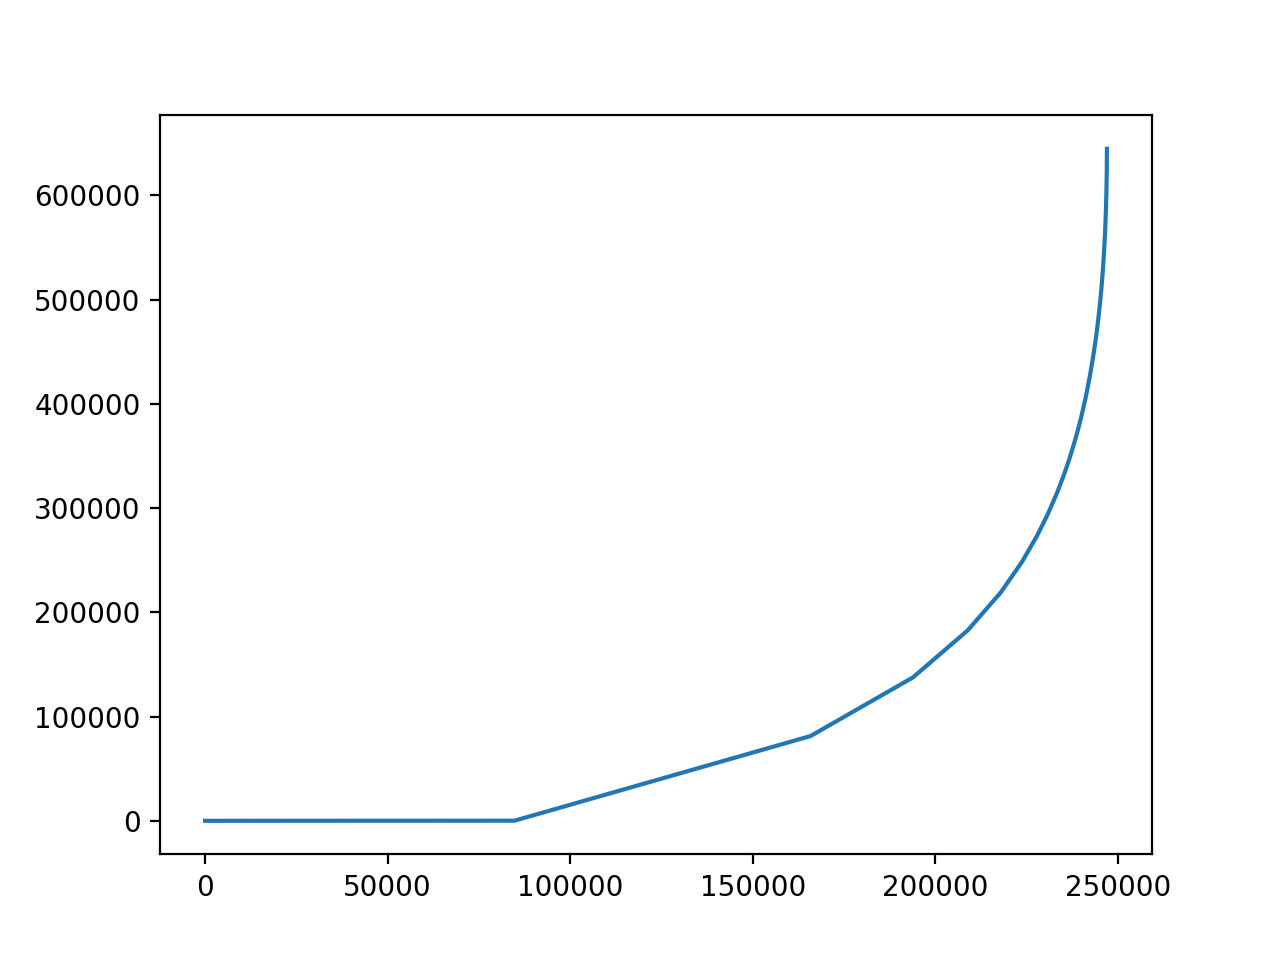

In [7]:
%matplotlib notebook
y = posts.sort_values(by='likes')['likes'].cumsum()
plt.plot(y.reset_index(drop=True))
plt.show()

In [8]:
np.sum(posts['likes'] == 0) / posts.shape[0]

0.34267927903861023

In [9]:
np.sum(posts['likes'] <= 1) / posts.shape[0]

0.6709449969440499

Likes per account

In [10]:
accounts = pd.concat([likes['subjectDid'], likes['authorDid'], posts['authorDid']])

accounts = pd.DataFrame({'account': accounts.unique()})

accounts

account
0      did:plc:lsmyaz23a3i3r75qki423npq
1      did:plc:wd5brnxbsbcexgmvnkenkfm3
2      did:plc:kdqmfumjc75chgkf7npqw5hz
3      did:plc:pcdqvg6ox7mp67s4wowpqmiu
4      did:plc:dmmive6fhnvwl5clkhv4tpbc
...                                 ...
91071  did:plc:tru4524pbky2wgxuf37oat6d
91072  did:plc:7w4gxtfhm5twmuddq2bdgdkn
91073  did:plc:kwitm3p4rrv5tfy4hx2ayrzb
91074  did:plc:tjqi5lvhbzfs22x2fivei2kk
91075  did:plc:3dsgnxr4tjubb437zrwlmyox

[91076 rows x 1 columns]

In [11]:
account_likes = likes.groupby('subjectDid'
    ).agg(likes=('uri', 'count')
    ).reset_index(
    ).rename(columns={'subjectDid':'account'})
account_likes

account  likes
0      did:plc:222ocxmd3qfo5pn7juncj5ds      5
1      did:plc:222p42fegwhwfyrc3gqam76j     10
2      did:plc:222rnvnta2lbl364bog2plxw      5
3      did:plc:223bx4usklxh4ub66jh6kdwa      2
4      did:plc:223lngzlhynd26g772d4fwsc      1
...                                 ...    ...
54217  did:plc:zzxhygmujxo3k64ailvouiti      5
54218  did:plc:zzxwledpqf7ob7svaf675k4c      3
54219  did:plc:zzza7zo2lho4etts27epjgpc      3
54220  did:plc:zzzfnodmpmaqmyugvi77j7bi      5
54221  did:plc:zzzjyeyecqee2ejfgxxobm7e      4

[54222 rows x 2 columns]

In [12]:
accounts = accounts.merge(account_likes, left_on='account', right_on='account', how='left')
accounts.loc[accounts['likes'].isna(), 'likes'] = 0

<IPython.core.display.Javascript object>


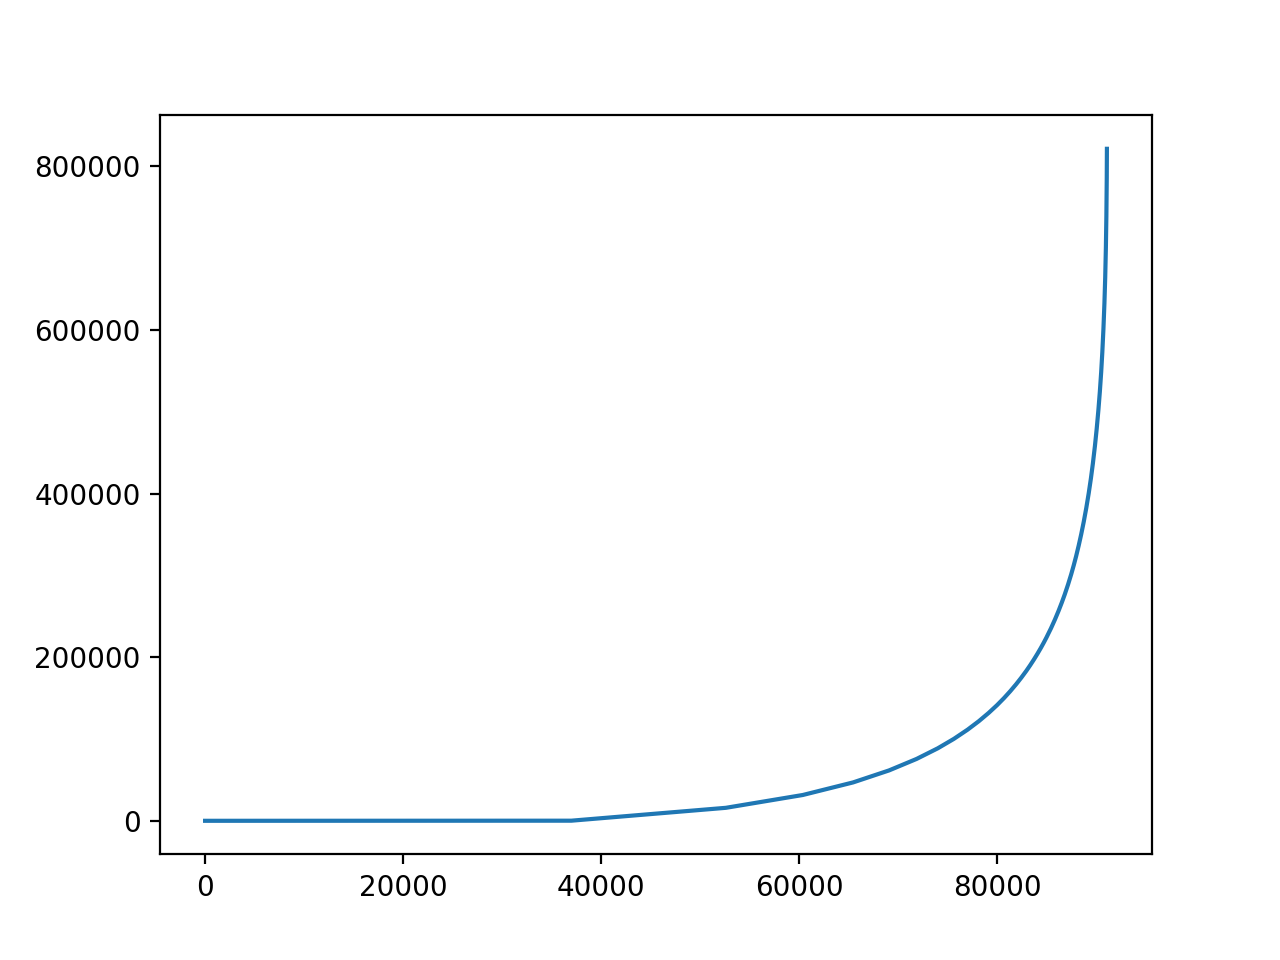

In [13]:
%matplotlib notebook
y_accounts = accounts.sort_values(by='likes')['likes'].cumsum().reset_index(drop=True)
plt.plot(y_accounts)
plt.show()

In [14]:
quants = [0, 0.25, 0.5, 0.75, 0.9, .95, .99]
quantiles = accounts['likes'].quantile(quants)
quantiles

0.00      0.0
0.25      0.0
0.50      1.0
0.75      4.0
0.90     15.0
0.95     32.0
0.99    137.0
Name: likes, dtype: float64

In [15]:
sorted_accounts = accounts.sort_values(by='likes')
quant_idx = [np.where(sorted_accounts['likes'] >= q)[0][0] for q in quantiles]
quant_idx

[0, 0, 36854, 65304, 81702, 86403, 90162]

In [16]:
np.where(sorted_accounts['likes'] > 0)

(array([36854, 36855, 36856, ..., 91073, 91074, 91075]),)

<IPython.core.display.Javascript object>


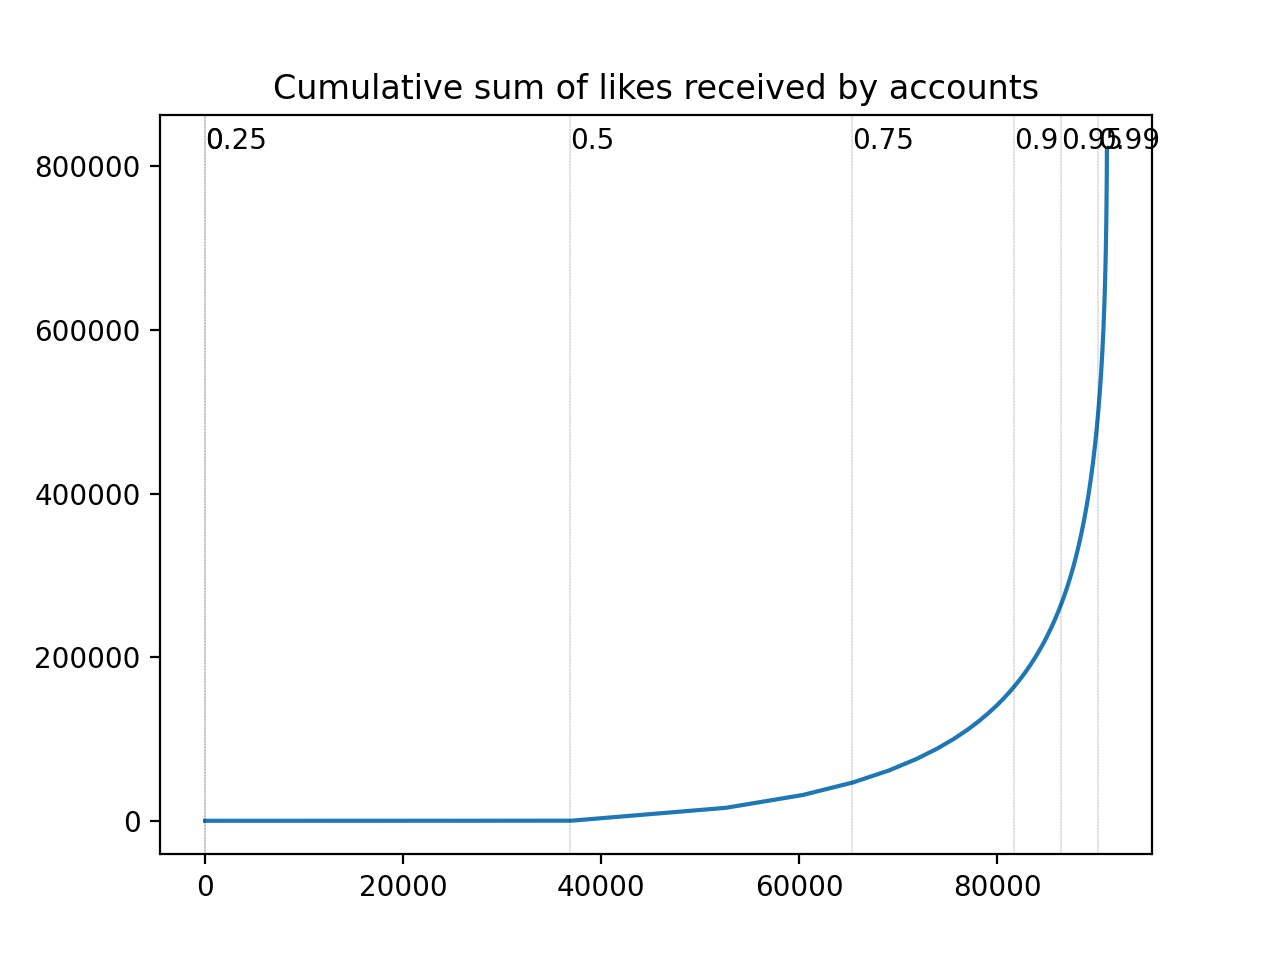

In [17]:
%matplotlib notebook

cumsum_accounts = sorted_accounts['likes'].cumsum().reset_index(drop=True)

plt.plot(cumsum_accounts)

for q_label, q_idx in zip(quants, quant_idx):
    plt.axvline(x=q_idx, color='black', linestyle='--', linewidth=.1)
    plt.annotate(text=str(q_label), xy=(q_idx, max(cumsum_accounts)), xycoords='data')

plt.title('Cumulative sum of likes received by accounts')    

plt.show()

In [18]:
len(accounts[accounts['likes']==0]['likes']) / len(accounts)

0.4046510606526417

Proportion of interactions received by the 99th and 95th percentile of most interacted with accounts

In [19]:
percentile = 0.99
accounts.loc[accounts['likes'] >= quantiles[percentile], 'likes'].sum() / accounts['likes'].sum()

0.3979456206591834

In [116]:
percentile = 0.95
accounts.loc[accounts['likes'] >= quantiles[percentile], 'likes'].sum() / accounts['likes'].sum()

0.759416544458887

Excluding interactions with the top (percentile) accounts

In [117]:
top_accounts = accounts.loc[accounts['likes'] >= quantiles[percentile]]


In [118]:
top_posts = posts.loc[posts['authorDid'].isin(top_accounts['account'])]
non_top_posts = posts.loc[~posts['authorDid'].isin(top_accounts['account'])]
top_threads = posts.loc[np.logical_or(
    posts['replyRoot'].isin(top_posts['uri']),
    posts['replyParent'].isin(top_posts['uri'])
)]

In [119]:
non_top_reply_likes = likes.loc[
    np.logical_and(
        ~likes['subjectUri'].isin(top_threads['uri']),
        ~likes['subjectDid'].isin(top_accounts['account'])
    )]
non_top_account_likes = likes.loc[
    ~likes['subjectDid'].isin(top_accounts['account'])
]

non_top_reply_likes

uri  \
2        at://did:plc:tt2krpcels6fzdwt5e2iold6/app.bsky...   
3        at://did:plc:wdcuds3huxctzwn35sbvskmb/app.bsky...   
7        at://did:plc:ufdixs5k6dx6yhfr5a4dr5ax/app.bsky...   
14       at://did:plc:wdcuds3huxctzwn35sbvskmb/app.bsky...   
16       at://did:plc:4mip3xdpj2iasxiqchzgn4sc/app.bsky...   
...                                                    ...   
1043980  at://did:plc:r23oqmp22lkgvynjji7g3jyn/app.bsky...   
1043983  at://did:plc:m3dpze6kfymikzhyorn3yjve/app.bsky...   
1043984  at://did:plc:uogqw3tmescpszxmep6e64x2/app.bsky...   
1043985  at://did:plc:i3xuhvb7fndx2r2fhfkyi6r2/app.bsky...   
1043986  at://did:plc:mxroexojpobpj4e7346mb6hm/app.bsky...   

                                                       cid  \
2        bafyreib3ozumx3qi3mb7wqmhedj2fftrosycnksyt25xc...   
3        bafyreicosgwinajfnon2splv5u2o6zyiax5trhf6vdxlh...   
7        bafyreih3pmj7hehirajk6xpqejkzs7iyrpt4ausft3wqs...   
14       bafyreiardnphqnh554j6ivjdgr4aaojcoxrrnqopbg6od...   
16       bafyreiduxwt6r6k7sr5oxti4ftrrogwnasjjofaptf3th...   
...                                                    ...   
1043980  bafyreibwqvsnvahf3ntoc6hw7fo752k43xeci6o2uatbx...   
1043983  bafyreibfosoiywciqecjxtuymtcmq3ovzwgi4ot2wtweq...   
1043984  bafyreib6wq6uv4n6hpzgq7hosxsoynp47tpwyesncegya...   
1043985  bafyreicgukln6qco5dy5vypm6piqh6tr2nvoppm7dal7q...   
1043986  bafyreif4suaf5eve4gyj5efn4z6ca6zmgygkp2pur7bqw...   

                                authorDid                 indexedAt  \
2        did:plc:tt2krpcels6fzdwt5e2iold6  2023-06-28T06:50:32.931Z   
3        did:plc:wdcuds3huxctzwn35sbvskmb  2023-06-28T06:50:33.759Z   
7        did:plc:ufdixs5k6dx6yhfr5a4dr5ax  2023-06-28T06:50:34.059Z   
14       did:plc:wdcuds3huxctzwn35sbvskmb  2023-06-28T06:50:37.626Z   
16       did:plc:4mip3xdpj2iasxiqchzgn4sc  2023-06-28T06:50:38.198Z   
...                                   ...                       ...   
1043980  did:plc:r23oqmp22lkgvynjji7g3jyn  2023-06-30T03:27:29.874Z   
1043983  did:plc:m3dpze6kfymikzhyorn3yjve  2023-06-30T03:27:29.973Z   
1043984  did:plc:uogqw3tmescpszxmep6e64x2  2023-06-30T03:27:30.072Z   
1043985  did:plc:i3xuhvb7fndx2r2fhfkyi6r2  2023-06-30T03:27:30.182Z   
1043986  did:plc:mxroexojpobpj4e7346mb6hm  2023-06-30T03:27:30.244Z   

                        createdAt  \
2        2023-06-28T06:50:32.736Z   
3        2023-06-28T06:50:33.539Z   
7        2023-06-28T06:50:31.813Z   
14       2023-06-28T06:50:37.483Z   
16       2023-06-28T06:50:37.964Z   
...                           ...   
1043980  2023-06-30T03:27:30.228Z   
1043983  2023-06-30T03:27:29.696Z   
1043984  2023-06-30T03:27:30.021Z   
1043985  2023-06-30T03:27:29.923Z   
1043986  2023-06-30T03:27:29.530Z   

                                                subjectUri  \
2        at://did:plc:m2hze6zxa744iberzknpkc3i/app.bsky...   
3        at://did:plc:ykzmsemoxmlzmrci2p77eqkm/app.bsky...   
7        at://did:plc:yx6bxsdt445ybmjwu362riaw/app.bsky...   
14       at://did:plc:yt5iskeftjmml3xiuhw5svxl/app.bsky...   
16       at://did:plc:hb3rpuqloy36skpistigbc3q/app.bsky...   
...                                                    ...   
1043980  at://did:plc:6kdg7avq4vqjgvciwdp5eb6w/app.bsky...   
1043983  at://did:plc:wfvahw2jy6eonvvh5wwx2njs/app.bsky...   
1043984  at://did:plc:4u42vwglz35baspkeivbgw3n/app.bsky...   
1043985  at://did:plc:shmltckvsbkhjbcb4mwdeplx/app.bsky...   
1043986  at://did:plc:xridcxx3se5arspf5dtk2ahm/app.bsky...   

                                                subjectCid  \
2        bafyreibbhg6hz64gakzkptazxpwstfbbbid6a4fw6w5m5...   
3        bafyreidheno2szedmn2ckwtm6zuoadsaxq2rpmgef2bvt...   
7        bafyreigupyvy2fdwglafoix3a3cgqgj43pmghearauqbx...   
14       bafyreicdboh6uublfn6zbalxg7sqx57m77d4ubtvuobv3...   
16       bafyreidblyfdtqqnvf7uxh2flv3btil42qywbbws7ucrn...   
...                                                    ...   
1043980  bafyreiavih4pssn376ltytm2nbvrs3gt5wf7maly5e6x4...   
1043983  bafyreidyyxu6ywje

Proportion of posts from top posters

In [120]:
top_posts.shape[0] / posts.shape[0]

0.5337081682060915

Proportion of non-top account likes that are not in threads with top accounts

In [121]:
non_top_reply_likes.shape[0] / non_top_account_likes.shape[0]

0.8454528081030076

Proportion of likes to non-top accounts

In [122]:
non_top_account_likes.shape[0] / likes.shape[0]

0.24058345554111307

Proportion of likes to non-top accounts that are not in threads with top accounts

In [123]:
non_top_reply_likes.shape[0] / likes.shape[0]

0.2034019580703591

Number of top accounts

In [124]:
top_accounts.shape[0]

2306

Quantiles of likes received by non-top posts

In [125]:
non_top_posts['likes'].quantile(quants)

0.00     0.0
0.25     0.0
0.50     1.0
0.75     2.0
0.90     3.0
0.95     6.0
0.99    13.0
Name: likes, dtype: float64

In [126]:
sum(non_top_posts['likes'] <= 1) / non_top_posts.shape[0]

0.7470756751975067

In [127]:
non_top_posts['likes'].max()

70.0

In [128]:
top_posts['likes'].max()

3189.0

How many accounts who posted received any likes?

In [129]:
posting_account_likes = posts.groupby('authorDid'
    ).agg(
      likes=('likes', 'sum'),
      posts=('uri', 'count')
    ).reset_index()

In [130]:
sum(posting_account_likes['likes'] == 0) / posting_account_likes.shape[0]

0.23161960993687383

In [131]:
posting_account_likes['likes_per_post'] = \
    posting_account_likes['likes'] / posting_account_likes['posts']

In [132]:
lpp_quantiles = posting_account_likes['likes_per_post'].quantile(quants)
lpp_quantiles

0.00     0.000000
0.25     0.250000
0.50     1.000000
0.75     2.285714
0.90     4.750000
0.95     7.000000
0.99    16.640000
Name: likes_per_post, dtype: float64

In [133]:
nontop_lpp_quantiles = posting_account_likes[
    ~posting_account_likes['authorDid'].isin(top_accounts['account'])
]['likes_per_post'].quantile(quants)
nontop_lpp_quantiles

0.00     0.000000
0.25     0.019419
0.50     1.000000
0.75     2.000000
0.90     4.000000
0.95     6.000000
0.99    12.000000
Name: likes_per_post, dtype: float64

<IPython.core.display.Javascript object>


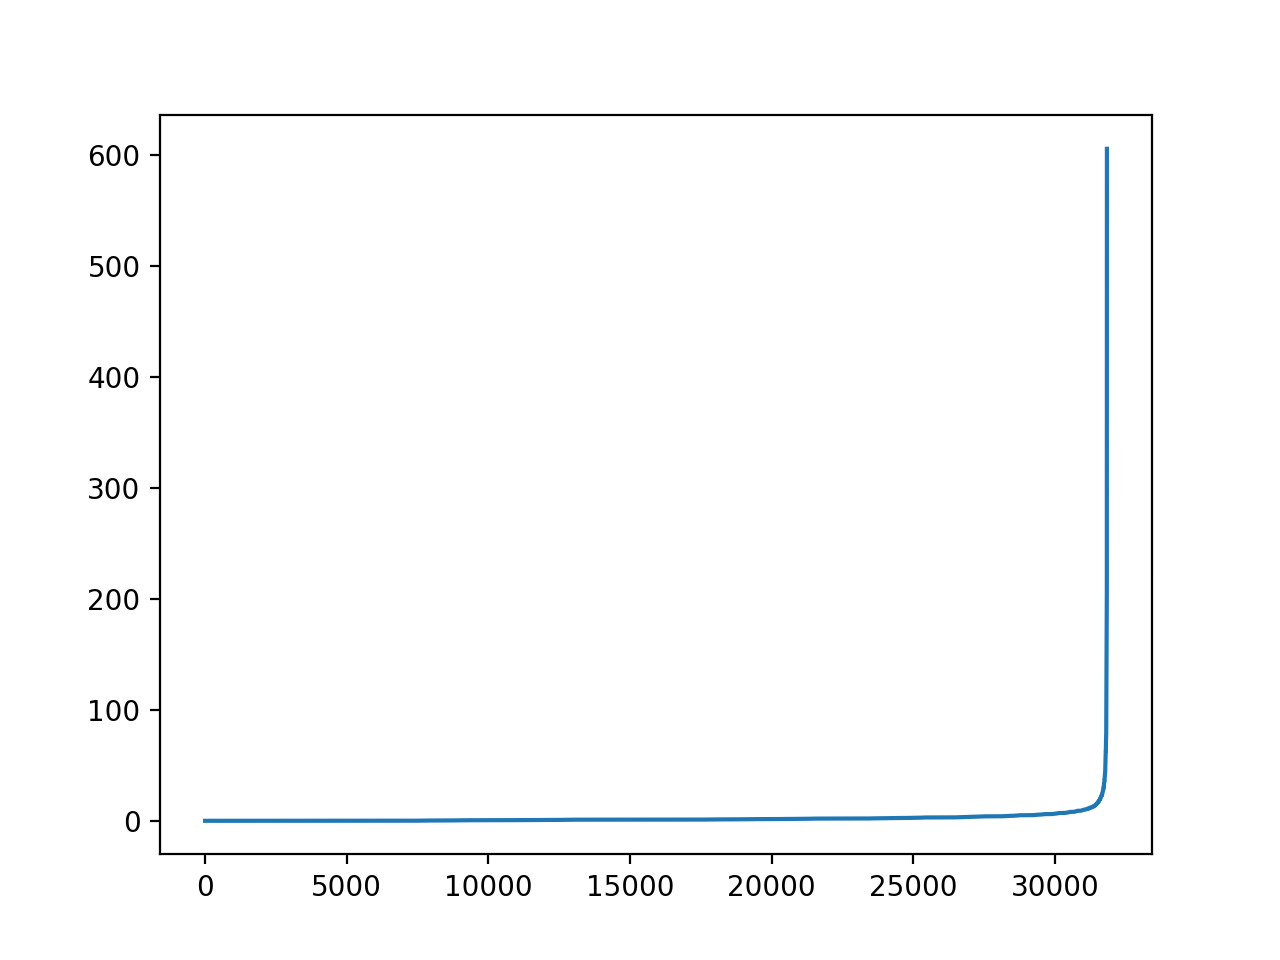

In [134]:
%matplotlib notebook
lpp_sorted = posting_account_likes.sort_values('likes_per_post').reset_index()
plt.plot(lpp_sorted['likes_per_post'])
plt.show()

In [142]:
non_posting_accounts = accounts[~accounts['account'].isin(posting_accounts)]
non_posting_accounts

account  likes
2      did:plc:m2hze6zxa744iberzknpkc3i   12.0
14     did:plc:hb3rpuqloy36skpistigbc3q    2.0
27     did:plc:vnifedvv4yrjwvi345i6ojyo    3.0
39     did:plc:fxgi2crlym2f3ogvygpysomv    3.0
47     did:plc:d6sjqoyj3f234j2xzbnup3xv    2.0
...                                 ...    ...
42435  did:plc:fv4ocfi7ztdxwma2wgq3mrpl    0.0
42436  did:plc:6xizlc72q3qrkxaqnnfazf6v    0.0
42437  did:plc:treg3m5eyfqly26syzyif4rv    0.0
42438  did:plc:aq4s2bchpelfyxyj6d2lnq7v    0.0
42440  did:plc:7jhmbeill5icysvwsqgaxnss    0.0

[13829 rows x 2 columns]

In [145]:
non_posting_accounts.shape[0] / accounts.shape[0]

0.30280271513028245

In [146]:
accounts.shape[0]

45670

In [151]:
sum(non_posting_accounts['likes'] > 0) / non_posting_accounts.shape[0]

0.31687034492732663

In [147]:
non_posting_accounts['likes'].sum() / accounts['likes'].sum()

0.010815268772503873

In [90]:
top_accounts

account   likes
0      did:plc:nvog7rczakwzh5ckxnjnwqdd  2009.0
1      did:plc:z3eu4ec7csnznxrrdrabudgj   331.0
4      did:plc:afrooick4a2hy2m2eme5ognc   103.0
6      did:plc:zsdhduo2ahpdhfa73uynnbf2   605.0
7      did:plc:d7hb4uouljzujxvm55gnanr7   195.0
...                                 ...     ...
27941  did:plc:tjhlqxa4vqxr2yfgeykncuy6    94.0
28023  did:plc:oormkmckkga7koagos7yrcn7   105.0
28442  did:plc:z3mut2kadcqhm73epuj4vzyq   187.0
29049  did:plc:ituhatvv5pyz4rwsj4hfrslh    91.0
29179  did:plc:zltiiulpgfxsye6u7xd7qzjh    91.0

[2306 rows x 2 columns]

In [135]:
accounts

account   likes
0      did:plc:nvog7rczakwzh5ckxnjnwqdd  2009.0
1      did:plc:z3eu4ec7csnznxrrdrabudgj   331.0
2      did:plc:m2hze6zxa744iberzknpkc3i    12.0
3      did:plc:ykzmsemoxmlzmrci2p77eqkm    41.0
4      did:plc:afrooick4a2hy2m2eme5ognc   103.0
...                                 ...     ...
45665  did:plc:efkxngznfeo2onvrjhskmmou     0.0
45666  did:plc:pv4x356soulpp7spindi57gz     0.0
45667  did:plc:w5reveglbupc6sz4txst2v7b     0.0
45668  did:plc:7o6uylwbtcpwk5c5pqa67fsl     0.0
45669  did:plc:uppr7hyd3a2zzss54drq2s5j     0.0

[45670 rows x 2 columns]